In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jan 25, 2023
@author: Kemal
"""

# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Use Pandas to display all columns of DFs
pd.set_option('display.max_columns', None)

Data sources:
- EmlakJet.com (Istanbul Adverts)
- [İlçelerin Sosyo-Ekonomik Gelişmişlik Araştırması](https://www.sanayi.gov.tr/assets/pdf/birimler/2022-ilce-sege.pdf), T.C. Sanayi ve Teknoloji Bakanlığı, 2022 


Outline:
- Read the data
- Display general information about the dataset
- Exploratory Data Analysis
- Selecting features
- Evaluating model 

In [2]:
# Read the Data
df = pd.read_excel('emlakjet_istanbul_270123v2.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Fiyat (TL)              1498 non-null   int64  
 1   Şehir                   1498 non-null   object 
 2   İlçe                    1498 non-null   object 
 3   Mahalle                 1498 non-null   object 
 4   İlan Numarası           1498 non-null   int64  
 5   İlan Güncelleme Tarihi  1498 non-null   object 
 6   Kategorisi              1498 non-null   object 
 7   Brüt Metrekare          1498 non-null   float64
 8   Binanın Yaşı            1498 non-null   object 
 9   Binanın Kat Sayısı      1498 non-null   int64  
 10  Kullanım Durumu         1498 non-null   object 
 11  Yatırıma Uygunluk       1247 non-null   object 
 12  Yapı Tipi               694 non-null    object 
 13  İpotek Durumu           1498 non-null   object 
 14  Eşya Durumu             1498 non-null   

In [4]:
df['İlan Numarası'].duplicated().value_counts()

False    1478
True       20
Name: İlan Numarası, dtype: int64

In [5]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [6]:
# List of column names to be kept in the smaller DF. Most of the removed columns contains unncessary information.

cols_to_keep = ['Fiyat (TL)','İlçe', 'Binanın Yaşı', 'Yapı Tipi', 'Bulunduğu Kat Derece',
                'İpotek Durumu', 'Eşya Durumu', 'Banyo Sayısı',
                'Net Metrekare', 'Oda Sayısı','Yapı Durumu', 
                'Site İçerisinde', 'İlçe Derece']

In [7]:
# Create smaller DataFrame.

df2 = df[cols_to_keep]
df2.sort_values(by='Fiyat (TL)', ascending=False).head()

,Fiyat (TL),İlçe,Binanın Yaşı,Yapı Tipi,Bulunduğu Kat Derece,İpotek Durumu,Eşya Durumu,Banyo Sayısı,Net Metrekare,Oda Sayısı,Yapı Durumu,Site İçerisinde,İlçe Derece
1450,215000000,Ataşehir,4,NaN,2.0,Bilinmiyor,Boş,6+,3450,8+ Oda,İkinci El,Hayır,3
392,120000000,Sarıyer,1,Ahşap,1.0,Bilinmiyor,Bilinmiyor,6+,1100,8+ Oda,Sıfır,Hayır,3
512,96000000,Beykoz,11-15,NaN,1.0,Bilinmiyor,Boş,6+,2500,8+ Oda,İkinci El,Evet,4
1496,83000000,Bahçelievler,0 (Yeni),Betonarme,3.0,Bilinmiyor,Boş,1,3050,3+1,Sıfır,Hayır,4
511,75000000,Beykoz,21 Ve Üzeri,NaN,1.0,Bilinmiyor,Boş,4,2200,7+2,İkinci El,Hayır,4


# Functions

This part consists of functions to be used throughout the script. 
- Encoder
- Filter (Price Filter, Area Filter)
- Model Evaluater (Scikit Learn & StatsModel)
- Visualizer (Correlation, Pairplot via Pandas & Seaborn)


## Encoder Function

Use ``` feature_encoder(DataFrame, [SelectedFeatures]) ``` to obtain a dataframe that includes only selected features in a encoded form.

Function returns to a DataFrame object. If you like to try some features, call it using a new dataframe.

In [8]:
"""
Before moving on to exploratory data analysis, we shall "pre-preprocess" some features.
    (1) Replace "Binanın Yaşı" with ranked variables
    (2) Using "Oda Sayısı" -a str expression-, determine total number of rooms.
    (3) Replace "Banyo Sayısı" with numbers
    (4) Replace "Site İçerisinde" with numbers -- (Evet:0 , Hayır:1)
    (5) One-hot Encode "Yapı Durumu" 
    (6) One-hot Encode "Eşya Durumu" 
    (7) One-hot Encode "İpotek Durumu" 
"""

all_features = ['Fiyat (TL)','İlçe', 'Binanın Yaşı', 'Yapı Tipi', 'Bulunduğu Kat Derece',
                'İpotek Durumu', 'Eşya Durumu', 'Banyo Sayısı',
                'Net Metrekare', 'Oda Sayısı', 'Isıtma Tipi', 'Yapı Durumu', 
                'Site İçerisinde', 'İlçe Derece']

model_features = ['Fiyat (TL)', 'İlçe Derece', 'Binanın Yaşı', 'Bulunduğu Kat Derece',
                'İpotek Durumu', 'Eşya Durumu', 'Banyo Sayısı',
                'Net Metrekare', 'Oda Sayısı', 'Yapı Durumu', 
                'Site İçerisinde']

def feature_encoder(df, model_features):
    
    df = df[model_features]

    for feature in model_features:
        print(f'Controlling {feature}..')

        #if feature == 'Net Metrekare':
            #df['Log M2'] = np.log(df['Net Metrekare'])
            
            # Drop Net Metrekare and use Log M2 instead
            # Note that in order to see the effect, it should be commented out!
            #df.drop(columns=['Net Metrekare'], inplace = True)        

        if feature == 'Binanın Yaşı':
            # ============= (1) ===========
            df['Binanın Yaşı'].replace({'0 (Yeni)':0, 
                                        '1':1, '2':1, '3':1, '4':1, 
                                        '5-10':2, 
                                        '11-15':3, 
                                        '16-20':4, 
                                        '21 Ve Üzeri':5}, inplace = True)
            
            print(f'Binanın Yaşı has been ranked successfuly!')
            print('------------------------------------------')

        if feature == 'Oda Sayısı':    
            # ============= (2) =========== 
            # I'll add "+" to single ones, split from "+" and sum them up to find "Oda Sayısı".
            df['Oda Sayısı'].replace({'8+ Oda':'8+3', 
                                        'Stüdyo':'1+0', 
                                        '1 Oda':'1+0',
                                        '5 Oda':'5+0',
                                        '1.5+1':'3+0',
                                        '4.5+1': '6+0',
                                        '3.5+1':'5+0'}, inplace = True)

            temp_df = df.copy()

            temp_df['Oda'] = df['Oda Sayısı'].str.split('+').str.get(0)
            temp_df['Salon'] = df['Oda Sayısı'].str.split('+').str.get(1)

            temp_df = temp_df.astype({'Oda':'int', 'Salon':'int'})

            df['Oda Sayısı'] = temp_df ['Oda'] + temp_df ['Salon']

            # Delete temporary dataframe
            del temp_df

            print(f'Oda Sayısı has been ranked successfuly!')
            print('----------------------------------------')

        if feature == 'Banyo Sayısı':
            # ============= (3) ===========
            df['Banyo Sayısı'].replace({'Yok':1, np.NAN:1, '6+':6}, inplace = True)

            print(f'Banyo Sayısı has been ranked successfuly!')
            print('------------------------------------------')
        
        if feature == 'Site İçerisinde':
            # ============= (4) ===========
            df['Site İçerisinde'].replace({'Evet':0, 'Hayır': 1}, inplace = True)

            print(f'Site İçerisinde has been ranked successfuly!')
            print('---------------------------------------------')
        
        if feature == 'Yapı Durumu':
            # ============= (5) ===========
            build_status = pd.get_dummies(df2[['Yapı Durumu']], drop_first = False)
            df = df.join(build_status)

            print(f'Yapı Durumu has been encoded successfuly!')
            print('------------------------------------------')
            df.drop(columns=['Yapı Durumu'], inplace = True)
        
        if feature == 'Eşya Durumu':
            # ============= (6) ===========
            esya_status = pd.get_dummies(df2[['Eşya Durumu']], drop_first = False)
            df = df.join(esya_status)

            print(f'Eşya Durumu has been encoded successfuly!')
            print('------------------------------------------')

            df.drop(columns=['Eşya Durumu'], inplace = True)

        if feature == 'İpotek Durumu':
            # ============= (7) ===========
            ipotek_status = pd.get_dummies(df2[['İpotek Durumu']], drop_first = False)
            df = df.join(ipotek_status)

            print(f'İpotek Durumu has been encoded successfuly!')
            print('--------------------------------------------')

            df.drop(columns=['İpotek Durumu'], inplace = True)

        #else:
            #df.drop(columns=[feature], inplace = True)
            #print(f'{feature} column has been dropped successfuly!')

    return df

## Filter Functions

Use ``` price_filter(DataFrame,min_price, max_price) ``` to filter prices in the dataset.

Use ``` area_filter(DataFrame,min_area, max_area) ``` to filter area in the dataset.

Both functions returns to a DataFrame object.

In [9]:
def price_filter(df,min_price, max_price):

    df = df[(df['Fiyat (TL)'] > min_price) & (df['Fiyat (TL)'] < max_price) ]

    return df

def area_filter(df,min_area, max_area):

    df = df[(df['Net Metrekare'] > min_area) & (df['Net Metrekare'] < max_area) ]

    return df

## Scikit Learn and StatsModel & Metric Functions

Use ``` evaluate_model_sk(DataFrame)``` to fit the model using ```Scikit Learn``` and print out the metrics.

Use ``` evaluate_model_sm(DataFrame)``` to fit the model using ```StatsModel``` and print out the metrics.


In [10]:
"""
Scikit Learn and StatsModel & Metric Functions
"""

def evaluate_model_sk(df):    

    X = df.drop(columns=['Fiyat (TL)'])
    y = df['Fiyat (TL)']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
    print('==========================================================')
    print('=================== SCIKIT LEARN MODEL ===================')
    print('==========================================================')
    print('Model is training using SKLearn..')
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    print('Model is evaluating..')
    y_pred = model.predict(X_test)

    print('----------------\nMETRICS\n-----------------')
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error: %.2f"%(mse))

    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:%.2f"%(rmse))

    r2 = r2_score(y_test, y_pred)
    print("R-Squared:%.2f"%(r2))

    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:%.2f"%(mae))

    # Print out the score:
    #test_score = model.score(X_test, y_test)
    #print('Test R2 Score:', round(test_score,3))

    # The coefficients and intercept
    print("Coefficients:",model.coef_)
    print("Intercept: ",model.intercept_,"\n")

def evaluate_model_sm(df):
    X = df.drop(columns=['Fiyat (TL)'])
    y = df['Fiyat (TL)']

    # add a constant column to the independent variables
    X = sm.add_constant(X) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
    
    
    
    
    print('==========================================================')
    print('==================== STATSMODEL MODEL ====================')
    print('==========================================================')
    
    print('Fitting the model using StatsModel..')

    # Fit the model
    model = sm.OLS(y_train, X_train).fit() 
    #model = sm.OLS(y, X).fit() 

    # Predict
    #y_pred = model.predict(X_test) 

    # Statsmodel summary
    print(model.summary())

    """
    print('----------------\nMETRICS\n-----------------')
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error: %.2f"%(mse))

    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:%.2f"%(rmse))

    r2 = r2_score(y_test, y_pred)
    print("R-Squared:%.2f"%(r2))

    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:%.2f"%(mae))
    """

def lasso_regression(df, alpha = 0.1):

    X = df.drop(columns=['Fiyat (TL)'])
    y = df['Fiyat (TL)']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
    
    print('==========================================================')
    print('==================== LASSO REGRESSION ====================')
    print('==========================================================')
    print('Model has been regulazied using L1 - Lasso..')

    model = Lasso(alpha=0.1) # initialize the model with a regularization strength of 0.1
    model.fit(X_train, y_train) # fit the model to the training data
    y_pred = model.predict(X_test) # make predictions on the test set

    print('----------------\nMETRICS\n-----------------')
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error: %.2f"%(mse))

    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:%.2f"%(rmse))

    r2 = r2_score(y_test, y_pred)
    print("R-Squared:%.2f"%(r2))

    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:%.2f"%(mae))


def ridge_regression(df,alpha = 0.1):

    X = df.drop(columns=['Fiyat (TL)'])
    y = df[['Fiyat (TL)']]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)
    
    print('==========================================================')
    print('==================== RIDGE REGRESSION ====================')
    print('==========================================================')
    print('Model has been regulazied using L2 - Ridge..')

    model = Ridge(alpha=alpha) # initialize the model with a regularization strength of 0.1
    model.fit(X_train, y_train) # fit the model to the training data
    y_pred = model.predict(X_test) # make predictions on the test set

    print('----------------\nMETRICS\n-----------------')
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error: %.2f"%(mse))

    rmse = np.sqrt(mse)
    print("Root Mean Squared Error:%.2f"%(rmse))

    r2 = r2_score(y_test, y_pred)
    print("R-Squared:%.2f"%(r2))

    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error:%.2f"%(mae))


## Visualizers

Use ```display_pairplot(DataFrame, kind = 'scatter', hue=None, save = False) ``` to pair-plot features of the model using ```Seaborn```.

Use ```corr_heatmap(DataFrame, corr_type = 'pearson', save = False)``` to display correleation matrix of the model using ```Seaborn```.

Both functions have ```save``` option, default is ```False```. If you like to save the transparent plots, use ```save = True``` as argument.


In [11]:
def display_pairplot(df,kind = 'scatter', hue=None, save = False, file_name = None):
    plt.figure(figsize=(14,16))
    sns.pairplot(df, kind = kind, hue = hue)

    if save == True:
        if file_name == None:
            plt.savefig('pair_plot.png', transparent=True)
        else:
            plt.savefig(file_name, transparent = True)

def corr_heatmap(df, corr_type = 'pearson',save = False, file_name = None): #or spearman
    plt.figure(figsize=(14,8))
    
     
    sns.heatmap(df.corr(corr_type), vmin=-1, vmax=1, cmap='seismic', annot=True, fmt='.2f')

    print(df.corr(corr_type)['Fiyat (TL)'].sort_values(ascending=False))

    if save == True:
        if file_name == None:
            plt.savefig('df_corr_%s.png'%(corr_type), transparent=True)
        else:
            plt.savefig(file_name, transparent = True)

# EDA and Evaluation

In [12]:
# General dataframe
df2 = df[cols_to_keep]

# Selected Features
model_features = ['Fiyat (TL)', 'İlçe Derece',  
                 'Banyo Sayısı', 'Net Metrekare'] #'Oda Sayısı','Bulunduğu Kat Derece'


model_df = feature_encoder(df2, model_features)
model_df = price_filter(model_df, 0.4e6, 30e6)

#plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = 'serif'

#corr_heatmap(model_df, ) #save = True, file_name='model_corr_matrix.png')


Controlling Fiyat (TL)..
Controlling İlçe Derece..
Controlling Banyo Sayısı..
Banyo Sayısı has been ranked successfuly!
------------------------------------------
Controlling Net Metrekare..


/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [13]:
# General dataframe
df2 = df[cols_to_keep]

# Selected Features
model_features = ['Fiyat (TL)', 'İlçe Derece', 
                 'Banyo Sayısı', 'Net Metrekare', 'Bulunduğu Kat Derece', 'Oda Sayısı']

model_df = feature_encoder(df2, model_features)
model_df = price_filter(model_df, 0.4e6, 20e6)

#plt.rcParams['text.usetex'] = True
#display_pairplot(model_df )#) save = False)

Controlling Fiyat (TL)..
Controlling İlçe Derece..
Controlling Banyo Sayısı..
Banyo Sayısı has been ranked successfuly!
------------------------------------------
Controlling Net Metrekare..
Controlling Bulunduğu Kat Derece..
Controlling Oda Sayısı..
Oda Sayısı has been ranked successfuly!
----------------------------------------


<ipython-input-8-e570a6ce7eb6>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Oda Sayısı'] = temp_df ['Oda'] + temp_df ['Salon']


In [14]:
model_df.head()
#display_pairplot(model_df, kind = 'scatter') # ,save=True)

,Fiyat (TL),İlçe Derece,Banyo Sayısı,Net Metrekare,Bulunduğu Kat Derece,Oda Sayısı
0,875000,5,1,110,0.0,3
1,4750000,3,1,135,0.0,3
3,450000,4,1,70,0.0,2
9,660000,5,1,90,0.0,3
10,549000,4,1,110,0.0,3


In [15]:
evaluate_model_sk(model_df)
evaluate_model_sm(model_df)

=================== SCIKIT LEARN MODEL ===================
Model is training using SKLearn..
Model is evaluating..
----------------
METRICS
-----------------
Mean Squared Error: 4828486550310.45
Root Mean Squared Error:2197381.75
R-Squared:0.63
Mean Absolute Error:1317833.73
Coefficients: [-1102812.23629147   968271.9505763     10593.43776874   379523.44367489
    74312.98999165]
Intercept:  3085193.9066227344 

==================== STATSMODEL MODEL ====================
Fitting the model using StatsModel..
                            OLS Regression Results                            
Dep. Variable:             Fiyat (TL)   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.618
Method:                 Least Squares   F-statistic:                     366.6
Date:                Fri, 03 Feb 2023   Prob (F-statistic):          4.56e-233
Time:                        09:45:29   Log-Likelihood:                -17949.
No. Observatio

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [16]:
lasso_regression(model_df,alpha = 10)
ridge_regression(model_df, alpha = 0.1)

==================== LASSO REGRESSION ====================
Model has been regulazied using L1 - Lasso..
----------------
METRICS
-----------------
Mean Squared Error: 4828486608626.58
Root Mean Squared Error:2197381.76
R-Squared:0.63
Mean Absolute Error:1317833.71
==================== RIDGE REGRESSION ====================
Model has been regulazied using L2 - Ridge..
----------------
METRICS
-----------------
Mean Squared Error: 4828536742439.19
Root Mean Squared Error:2197393.17
R-Squared:0.63
Mean Absolute Error:1317813.41


Fiyat (TL)              1.000000
Net Metrekare           0.708200
Banyo Sayısı            0.652871
Oda Sayısı              0.571969
Bulunduğu Kat Derece    0.214337
İlçe Derece            -0.152051
Name: Fiyat (TL), dtype: float64


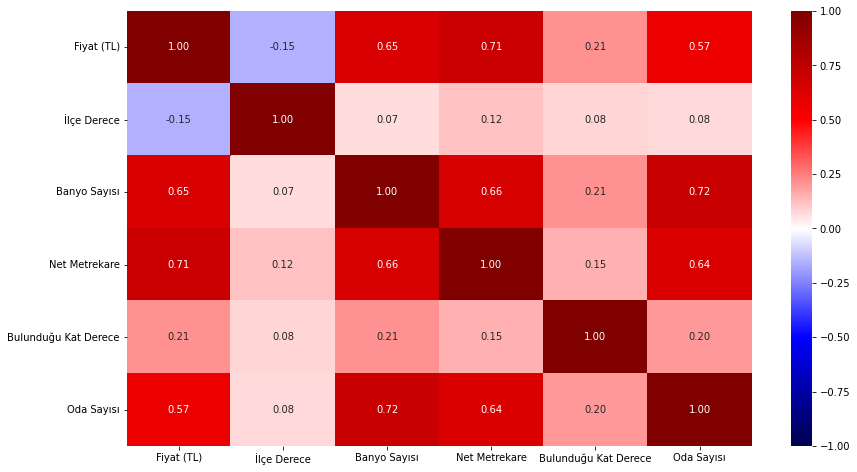

In [17]:
corr_heatmap(model_df)


Fiyat (TL)              1.000000
Net Metrekare           0.569263
Oda Sayısı              0.562926
Banyo Sayısı            0.545282
Bulunduğu Kat Derece    0.333057
İlçe Derece            -0.176767
Name: Fiyat (TL), dtype: float64


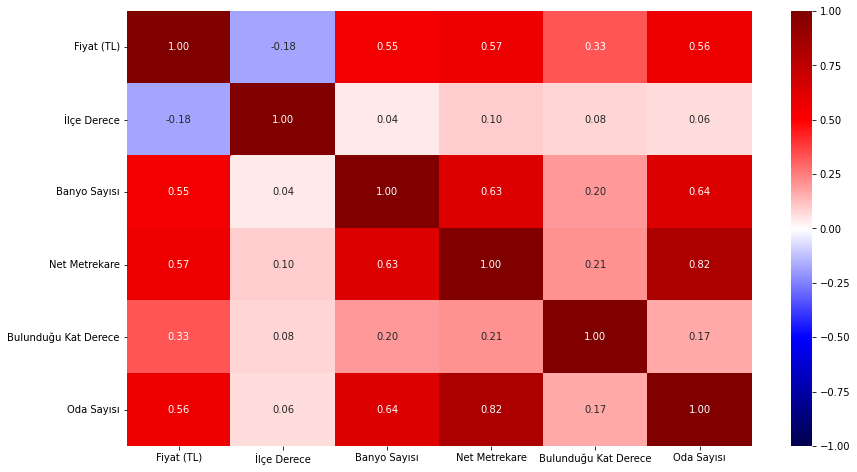

In [18]:
corr_heatmap(model_df, corr_type='spearman')

In [19]:
def cross_validation(df):

    models = ['LR', 'Lasso', 'Ridge']

    for m in models:

        X = df.drop(columns=['Fiyat (TL)'])
        y = df['Fiyat (TL)']

        if m == 'LR':
            print('---Linear Regression--')
            model = LinearRegression() # initialize the model with a regularization strength of 0.1
            #model.fit(X,y)
            scores = cross_val_score(model,X,y,cv=5, scoring='r2') # perform 5-fold cross-validation
            
            print("Cross-Validation Scores:", scores)
            print("Mean Score:", np.mean(scores))
            
        
        if m == 'Lasso':
            print('---Lasso--')
            model = Lasso(alpha=0.01) # initialize the model with a regularization strength of 0.1
            #model.fit(X,y)
            scores = cross_val_score(model, X, y,cv=5, scoring='r2') # perform 5-fold cross-validation
            
            print("Cross-Validation Scores:", scores)
            print("Mean Score:", np.mean(scores))
            

        if m == 'Ridge':
            print('---Ridge--')
            model = Ridge(alpha = 0.01) # initialize the model with a regularization strength of 0.1
            #model.fit(X,y)
            scores = cross_val_score(model, X, y,cv=5,scoring='r2') # perform 5-fold cross-validation
            
            print("Cross-Validation Scores:", scores)
            print("Mean Score:", np.mean(scores))
            

In [20]:
cross_validation(model_df)

---Linear Regression--
Cross-Validation Scores: [0.29630233 0.65607964 0.39074324 0.19617485 0.53377262]
Mean Score: 0.41461453743894816
---Lasso--
Cross-Validation Scores: [0.29630232 0.65607964 0.39074324 0.19617486 0.53377262]
Mean Score: 0.4146145359456079
---Ridge--
Cross-Validation Scores: [0.29630612 0.65607916 0.39074631 0.19618098 0.53377076]
Mean Score: 0.41461666568721045


In [21]:
model_df.head(5)

,Fiyat (TL),İlçe Derece,Banyo Sayısı,Net Metrekare,Bulunduğu Kat Derece,Oda Sayısı
0,875000,5,1,110,0.0,3
1,4750000,3,1,135,0.0,3
3,450000,4,1,70,0.0,2
9,660000,5,1,90,0.0,3
10,549000,4,1,110,0.0,3


In [22]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1412 entries, 0 to 1491
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Fiyat (TL)            1412 non-null   int64  
 1   İlçe Derece           1412 non-null   int64  
 2   Banyo Sayısı          1412 non-null   int64  
 3   Net Metrekare         1412 non-null   int64  
 4   Bulunduğu Kat Derece  1412 non-null   float64
 5   Oda Sayısı            1412 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 77.2 KB


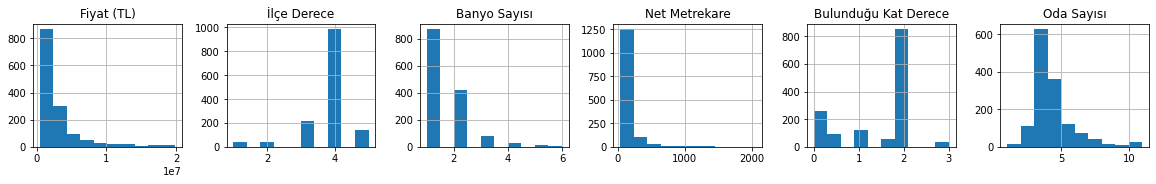

In [23]:
model_df.hist(layout = (6,6), sharex=False,figsize = (20,17))
plt.show()

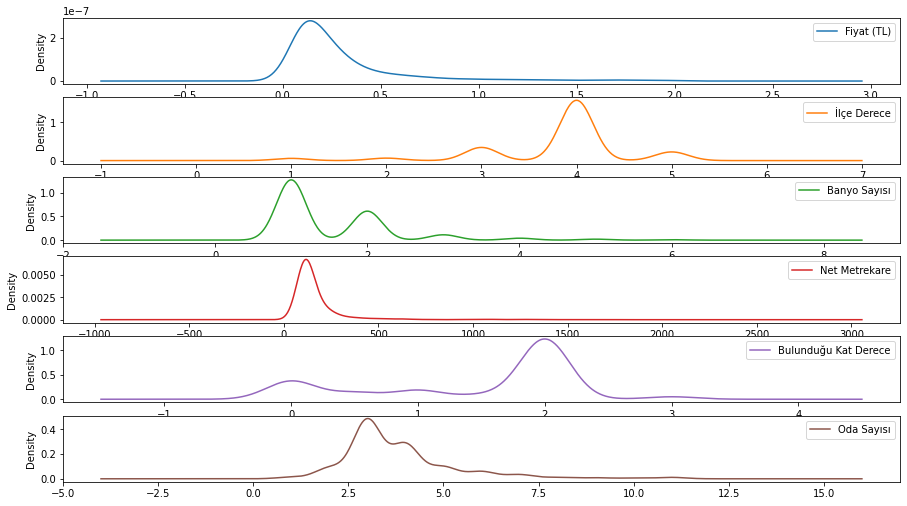

In [24]:
model_df.plot(kind='density', subplots=True, layout=(7,1), sharex=False,figsize = (15,10))
plt.show()

In [25]:
import plotly.express as px
px.bar(model_df,y="Banyo Sayısı",x="Oda Sayısı",color="Fiyat (TL)")

### Oversampling

In [26]:
# Split data into training and testing sets
X = model_df.drop(['Fiyat (TL)'],axis=1)
y = model_df['Fiyat (TL)']

#Creating the dict for the further models
model_dict = {"mse":[],"mae":[],"rmse":[],"r2":[]}

In [27]:
X_1 = X[:1200]
y_1 = y[:1200]

X_val = X[1200:]
y_val = y[1200:]

In [28]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto')
X_resampled, y_resampled = ros.fit_resample(X_1, y_1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state = 25)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(8553, 5) (8553,) (2139, 5) (2139,)


In [30]:
print('---Linear Regression--')
model = LinearRegression() # initialize the model with a regularization strength of 0.1
#model.fit(X,y)
scores = cross_val_score(model,X_resampled,y_resampled,cv=5, scoring='r2') # perform 5-fold cross-validation
            
print("Cross-Validation Scores:", scores)
print("Mean Score:", np.mean(scores))

print('---Lasso--')
model = Lasso(alpha=0.01) # initialize the model with a regularization strength of 0.1
#model.fit(X,y)
scores = cross_val_score(model, X_resampled, y_resampled,cv=5, scoring='r2') # perform 5-fold cross-validation
            
print("Cross-Validation Scores:", scores)
print("Mean Score:", np.mean(scores))

print('---Ridge--')
model = Ridge(alpha = 0.01) # initialize the model with a regularization strength of 0.1
#model.fit(X,y)
scores = cross_val_score(model, X_resampled, y_resampled,cv=5,scoring='r2') # perform 5-fold cross-validation
            
print("Cross-Validation Scores:", scores)
print("Mean Score:", np.mean(scores))

---Linear Regression--
Cross-Validation Scores: [   0.5626368  -125.14716214  -41.93822411   -8.5615514    -0.2293355 ]
Mean Score: -35.0627272678813
---Lasso--
Cross-Validation Scores: [   0.5626368  -125.14716266  -41.93822334   -8.56155123   -0.22933552]
Mean Score: -35.06272718816999
---Ridge--
Cross-Validation Scores: [   0.56263711 -125.14717651  -41.93811654   -8.56153184   -0.22933642]
Mean Score: -35.06270483761082


### Hyperparameter Tuning

In [31]:
from sklearn.model_selection import GridSearchCV

# set up the parameters for the grid search
param_grid = {'alpha': np.logspace(-3, 3, 7)}

# initialize the Ridge regression model
ridge = Ridge()

# perform the grid search with cross-validation
grid_search = GridSearchCV(ridge, param_grid, cv=5)
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
y_val_pred = grid_search.predict(X_val)

# print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# evaluate the best model on the test data
grid_search.score(X_test, y_test)

# Calculate mean squared error and R-squared
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)
rms = mean_squared_error(y_test, y_pred, squared=False)

# Print results
print(f'Mean squared error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'RMSE: {rms:.2f}')
print(f'R-squared: {r2:.2f}')

Best parameters: {'alpha': 10.0}
Best score: 0.6722276238070715
Mean squared error: 4257598513239.39
Mean Absolute Error: 1315191.30
RMSE: 2063394.90
R-squared: 0.62


In [32]:
y_pred_l = list(y_pred)
y_test_l = list(y_test)

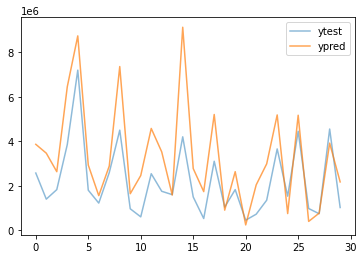

In [33]:
plt.plot(y_test_l[220:250], label='ytest',alpha=0.5)
plt.plot(y_pred_l[220:250], label='ypred',alpha=0.7)

plt.legend()
plt.show()

In [34]:
y_val_pred_l = list(y_val_pred)
y_val_l = list(y_val)

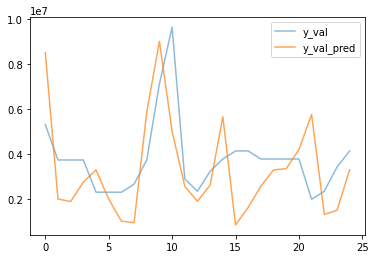

In [35]:
plt.plot(y_val_pred_l[10:35], label='y_val',alpha=0.5)
plt.plot(y_val_l[10:35], label='y_val_pred',alpha=0.7)

plt.legend()
plt.show()

In [36]:
# Calculate mean squared error and R-squared
mse = mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val,y_val_pred)
r2 = r2_score(y_val, y_val_pred)
rms = mean_squared_error(y_val, y_val_pred, squared=False)

# Print results
print(f'Mean squared error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'RMSE: {rms:.2f}')
print(f'R-squared: {r2:.2f}')

Mean squared error: 10174802356879.19
Mean Absolute Error: 2416961.38
RMSE: 3189796.60
R-squared: 0.50
